In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')


In [267]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_submission = pd.read_csv('data/sample_submission.csv')

In [268]:
print(f'The Train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
print(f'The Test dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns')

The Train dataset has 188533 rows and 13 columns
The Test dataset has 125690 rows and 12 columns


In [269]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [270]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [271]:
df = pd.concat([df_train, df_test], axis=0)

In [272]:
df.drop(columns=['id'], inplace=True)

## Milage

In [273]:
df.milage.isna().sum()

0

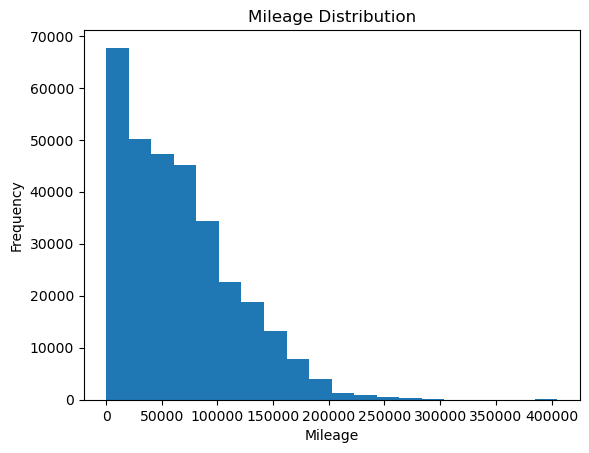

In [274]:
import matplotlib.pyplot as plt

# Plot the distribution of mileage
plt.hist(df['milage'], bins=20)
plt.title('Mileage Distribution')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

### Normalizing Milage Data

In [275]:
from sklearn.preprocessing import MinMaxScaler

# Assume df is your DataFrame and 'milage' is the column you want to normalize
scaler = MinMaxScaler()

# Reshape the data if you are working with a single column
df['milage_normalized'] = scaler.fit_transform(df[['milage']])

# Display the first few rows to check the results
print(df[['milage', 'milage_normalized']].head())

   milage  milage_normalized
0  213000              0.526
1  143250              0.354
2  136731              0.337
3   19500              0.048
4    7388              0.018


## Dealing with fuel type and engine

In [276]:
df.fuel_type.isna().sum()

8466

In [277]:
df.fuel_type.value_counts()

fuel_type
Gasoline          276473
Hybrid             11508
E85 Flex Fuel       8929
Diesel              6641
–                   1319
Plug-In Hybrid       858
not supported         29
Name: count, dtype: int64

In [278]:
df.engine.isna().sum()

0

In [279]:
df.engine.value_counts().sort_values(ascending=False).head(5)

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel     5651
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel     4868
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel     4694
2.0L I4 16V GDI DOHC Turbo                       4513
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel    4090
Name: count, dtype: int64

### Extracting Horsepower, Engine Size, and Cylinder Count

In [280]:
import re

pattern_1 = r'(?:(\d{1,3}\.\d{1,3})HP)?\s*(\d{1,2}(?:\.\d{1,2})?)?\s*(?:L|\s*Liter)?\s*(?:[A-Za-z\s-]*)?(\d+)?\s*(?:V|I|Straight)?\s*(?:Cylinder)?'

# Apply regex for horsepower, engine size, and cylinder count
df[['horsepower', 'engine_size', 'cylinder_count']] = df['engine'].str.extract(pattern_1)

# Convert numeric fields to appropriate data types
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df['engine_size'] = pd.to_numeric(df['engine_size'], errors='coerce')
df['cylinder_count'] = pd.to_numeric(df['cylinder_count'], errors='coerce')

In [281]:
print("Horsepower NaN Count: ", df.horsepower.isna().sum())
print("Engine Size NaN Count: ", df.engine_size.isna().sum())
print("Cylinder Count NaN Count: ", df.cylinder_count.isna().sum())

Horsepower NaN Count:  55502
Engine Size NaN Count:  11113
Cylinder Count NaN Count:  23427


### Extracting Fuel Type

In [301]:
# Regex pattern for fuel type
pattern_2 = r'(Electric Motor|Electric Fuel System|Electric|Gasoline|Diesel|Flex Fuel|Plug-In Electric/Gas|Plug-In Electric|Plug-In Hybrid|Hybrid.*|Gas/Electric Hybrid)'

# Apply regex for fuel type
df['engine_fuel_type'] = df['engine'].str.extract(pattern_2)

# Check the result
print(df['engine_fuel_type'].value_counts(dropna=False))

engine_fuel_type
Gasoline                233024
NaN                      52561
Flex Fuel                 8551
Electric Motor            8230
Diesel                    6889
Gas/Electric Hybrid       2565
Plug-In Electric/Gas       893
Electric                   826
Hybrid                     684
Name: count, dtype: int64


In [305]:
df['engine_fuel_type'] = df['engine_fuel_type'].replace({
    'Electric Motor': 'Electric',
    'Plug-In Electric': 'Electric',
    'Gas/Electric Hybrid': 'Hybrid',
    'Plug-In Electric/Gas': 'Plug-In Hybrid',
    'Flex Fuel': 'Flex',
})
df.engine_fuel_type.value_counts()

engine_fuel_type
Gasoline          233024
Electric            9056
Flex                8551
Diesel              6889
Hybrid              3249
Plug-In Hybrid       893
Name: count, dtype: int64

In [304]:
df.fuel_type.value_counts()

fuel_type
Gasoline          276473
Hybrid             11508
E85 Flex Fuel       8929
Diesel              6641
–                   1319
Plug-In Hybrid       858
not supported         29
Name: count, dtype: int64

In [308]:
df['fuel_type'] = df['fuel_type'].replace({
    'E85 Flex Fuel': 'Flex',
    'not supported': np.nan,
    '–': np.nan
})
df.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          276473
Hybrid             11508
NaN                 9814
Flex                8929
Diesel              6641
Plug-In Hybrid       858
Name: count, dtype: int64

### Filling NaN values in fuel_type with engine_fuel_type

In [309]:
df.loc[df.fuel_type.isna(), 'fuel_type'] = df.loc[df.fuel_type.isna(), 'engine_fuel_type']
df.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          276587
Hybrid             11512
Flex                8932
Electric            8099
Diesel              6646
NaN                 1588
Plug-In Hybrid       859
Name: count, dtype: int64

## Cleaning other columns

In [313]:
df.ext_col.value_counts(dropna=False)

ext_col
Black                                      81028
White                                      73040
Gray                                       42193
Silver                                     28343
Blue                                       24272
Red                                        16548
Green                                       4556
Gold                                        2838
Brown                                       1920
Orange                                      1896
Beige                                       1820
Yellow                                      1603
Bright White Clearcoat                      1263
Diamond Black                               1170
Agate Black Metallic                        1056
Summit White                                 852
Silver Ice Metallic                          738
Mythos Black Metallic                        697
Midnight Black Metallic                      641
Granite Crystal Clearcoat Metallic           602
–           

In [ ]:
df['fuel_type'] = df['fuel_type'].replace({
    'E85 Flex Fuel': 'Flex',
    'not supported': np.nan,
    '–': np.nan
})
df.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          276473
Hybrid             11508
NaN                 9814
Flex                8929
Diesel              6641
Plug-In Hybrid       858
Name: count, dtype: int64

In [ ]:
df['fuel_type'] = df['fuel_type'].replace({
    'E85 Flex Fuel': 'Flex',
    'not supported': np.nan,
    '–': np.nan
})
df.fuel_type.value_counts(dropna=False)

fuel_type
Gasoline          276473
Hybrid             11508
NaN                 9814
Flex                8929
Diesel              6641
Plug-In Hybrid       858
Name: count, dtype: int64